In [1]:
import openslide
from generate_slides import load_annotations
from generate_slides import create_tiles_with_annotation
from generate_slides import show_tiles_statistics
from PIL import Image, ImageDraw
import copy
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
from train import torchDataset
from albumentations.pytorch import ToTensorV2
from train import torchDataset

# Fir virtualenv autocompletion.
%config Completer.use_jedi = False

In [2]:
slide = openslide.open_slide('../data/18H14294I.mrxs')
annotations = load_annotations('../data/')
annotation = annotations[0]['annotations']['1']
img_size = 1024

In [3]:
from albumentations import Flip, RandomBrightnessContrast, HueSaturationValue, Normalize, ToFloat, CLAHE, ToGray, FancyPCA

def get_train_transform():
    return A.Compose(
        [
            Flip(),
            RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
            A.OneOf([CLAHE(), FancyPCA()]),
            HueSaturationValue(
                hue_shift_limit=10, sat_shift_limit=50, val_shift_limit=50, p=0.8
            ),
            ToFloat(255),
            ToTensorV2(),
        ],
        bbox_params=A.BboxParams(format="pascal_voc", label_fields=["labels"]),
    )

In [4]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        image = image.squeeze().permute(1,2,0)
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()    

In [5]:
dataset = torchDataset(
    root='coco/train/data',
    annotations='coco/train/labels.json',
    transforms=get_train_transform(),
)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


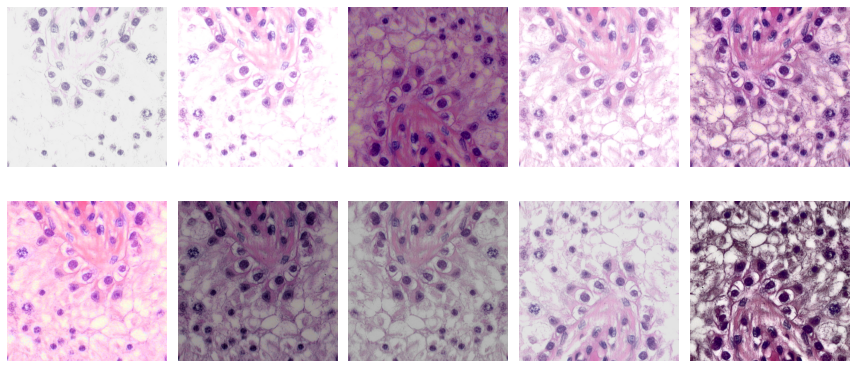

In [6]:
visualize_augmentations(dataset)

In [7]:
def clamp(val, smallest, largest):
    return max(smallest, min(val, largest))

In [11]:
def show_annotated_section(annotations, slide, lvl, image_size=1024):
    """
        Shows annotations in the image.
        image_size - returned image size
    """
    colors = {
        'label_color 1' : 'blue',
        'label_color 2' : 'green',
        'label_color 3' : 'red',
        'label_color 4' : 'yellow'
    }

    top_left = annotations['top_left']

    # Locate the region so that the annotation first
    # coordinate is in the middle of the section.
    img = slide.read_region(
        location = (top_left[0], top_left[1]),
        level = lvl,
        size = (image_size, image_size)
    )

    for annotation in annotations['annotations']:
        ann_type = annotation['geometry']['annotation_type']

        if ann_type != 'ELLIPSE':
            raise NotImplementedError
        ann_points = annotation["geometry"]["points"]
        x1, y1 = ann_points[0][0], ann_points[0][1]
        x2, y2 = ann_points[1][0], ann_points[1][1]

        # Points might be flipped.
        if x2 < x1:
            x2, x1 = x1, x2

        if y2 < y1:
            y2, y1 = y1, y2

        # Downscale
        downscale = int(slide.level_downsamples[lvl])
        x1, y1 = x1 // downscale, y1 // downscale
        x2, y2 = x2 // downscale, y2 // downscale

        # Drawing points are relative to the top left
        # as the new image top left is (0,0)
        point1 = [x1 - top_left[0] // downscale, y1 - top_left[1] // downscale]
        point2 = [x2 - top_left[0] // downscale, y2 - top_left[1] // downscale]

        # Limit points to the image border.
        # That also limits bbox to image border.
        point1 = [clamp(point1[0], 0, image_size ), clamp(point1[1], 0, image_size )]
        point2 = [clamp(point2[0], 0, image_size ), clamp(point2[1], 0, image_size )]

        width = point2[0] - point1[0]
        height = point2[1] - point1[1]
   
        # Color according to label.
        # White to check if there are missing labels.
        outline_color = 'white' 
        for key in annotation['user_attrs'].keys():
            if key in colors.keys():
                outline_color = colors[key]
    
        # Draw an ellipse over the image
        draw = ImageDraw.Draw(img)
        draw.rectangle(
            [
                (point1[0], point1[1]),
                (point2[0], point2[1])
            ],
            width=2,
            outline=outline_color
        )
    display(img)

In [9]:
an_tile = create_tiles_with_annotation(annotations[0], slide, lvl=2)
show_tiles_statistics(an_tile)

Zoom lvl: 		2
Tile size: 		1024
Total slides: 		18
Max annotations: 	69
Min annotations: 	1
Average annotations: 	11.11


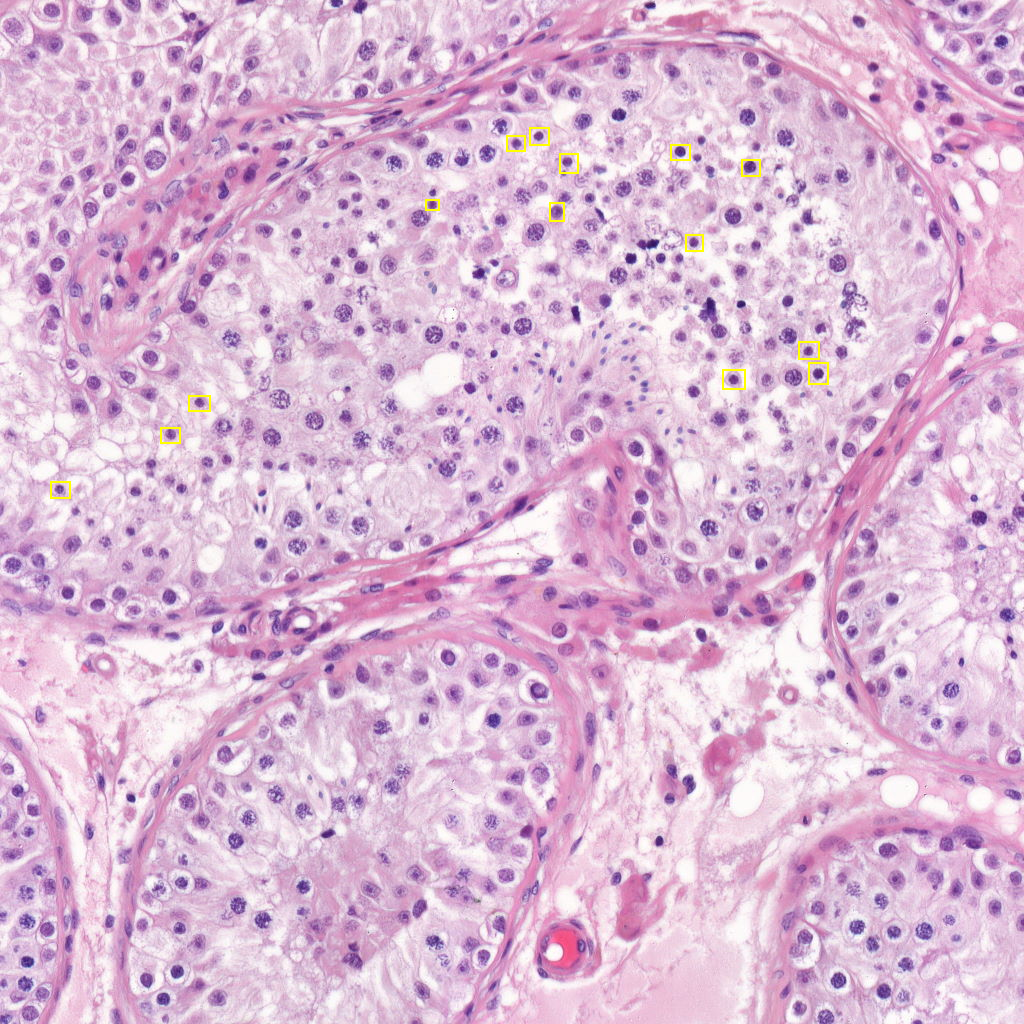

In [12]:
show_annotated_section(an_tile[0], slide, 2, image_size=1024)